In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.spatial.distance import cdist
from sklearn import datasets

## 1. KMeans

In [2]:
# import dataset and view head
compounds = pd.read_csv('compounds.csv')
compounds.head()

,A,B,C,D,type
0,6.4,2.9,4.3,1.3,amide
1,5.7,4.4,1.5,0.4,phenol
2,6.7,3.0,5.2,2.3,ether
3,5.8,2.8,5.1,2.4,ether
4,6.4,3.2,5.3,2.3,ether


### 1a 
Rescale the features to a value between 0 and 1 by dividing the column by the max of that feature.

In [3]:
def rescale_df(df):
    """
    Rescale the features of a dataframe to a value between 0 and 1 by dividing by the maximum value in that column.

    Parameters
    ----------
    df : pandas DataFrame
    The dataframe whose columns you wish to transform

    Returns
    -------
    df : pandas DataFrame
    The dataframe with transformed columns
    """
    for col in df.columns:
        df[col] = df[col] / df[col].max()
    
    return df

In [4]:
# make a copy of compounds
compounds_copy = compounds.copy()
# remove type column since it's a string and can't be rescaled
compounds_copy = compounds_copy.drop(columns = 'type')
# rescale features (columns A - D)
compounds_rescaled = rescale_df(compounds_copy)
# make a copy with just features (to use in 1b)
compounds_rescaled_features_only = compounds_rescaled.copy()
# add type column back
compounds_rescaled['type'] = compounds['type']
# show head to see if I've done the last few steps correctly
compounds_rescaled.head()

,A,B,C,D,type
0,0.810127,0.659091,0.623188,0.52,amide
1,0.721519,1.000000,0.217391,0.16,phenol
2,0.848101,0.681818,0.753623,0.92,ether
3,0.734177,0.636364,0.739130,0.96,ether
4,0.810127,0.727273,0.768116,0.92,ether


Now we plot to visualize any correlation between features.

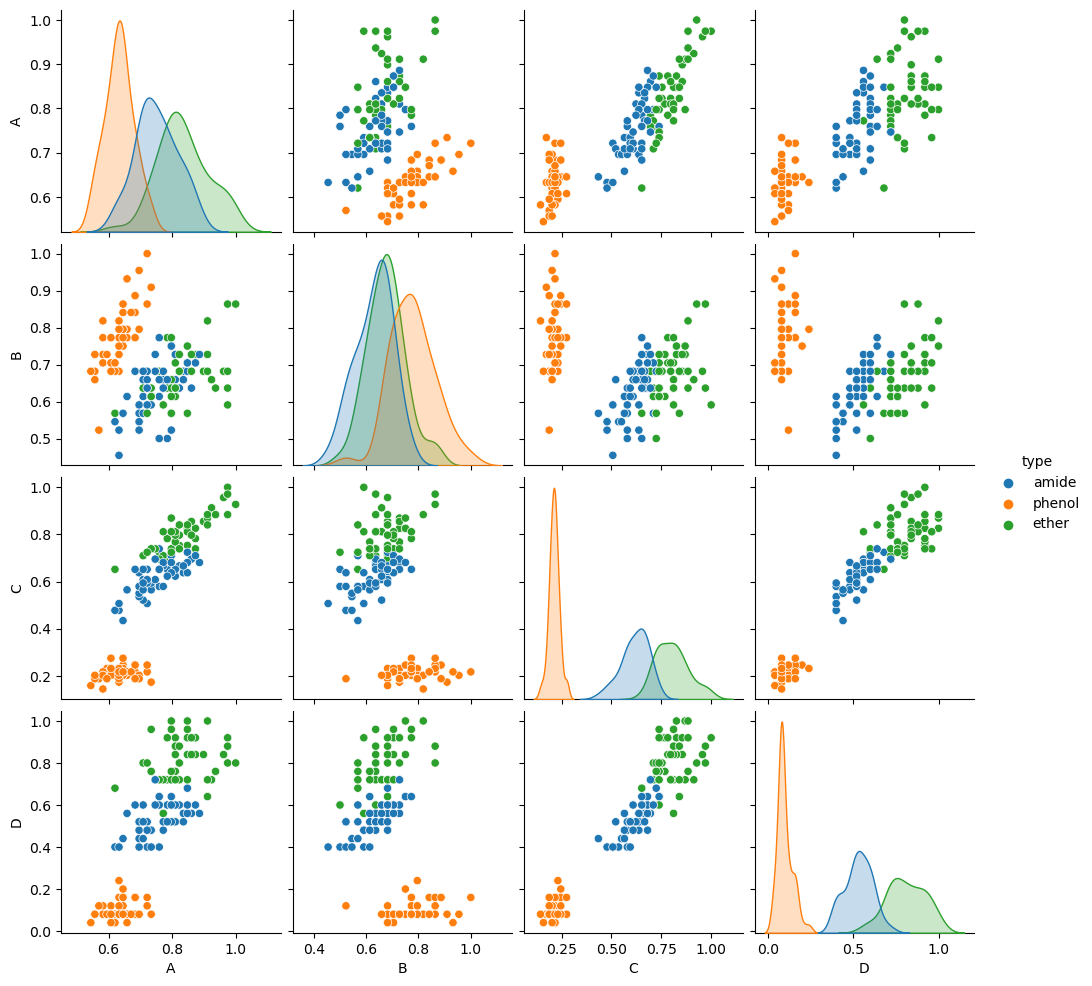

In [5]:
sns.pairplot(data=compounds_rescaled, hue='type', diag_kind='auto')

Looking at the graphs above, we see these correlations:
- C & D have a strong positive correlation
- I think A is correlated with C and D as well. It looks like a steep positive correlation

Now let's try a heatmap.

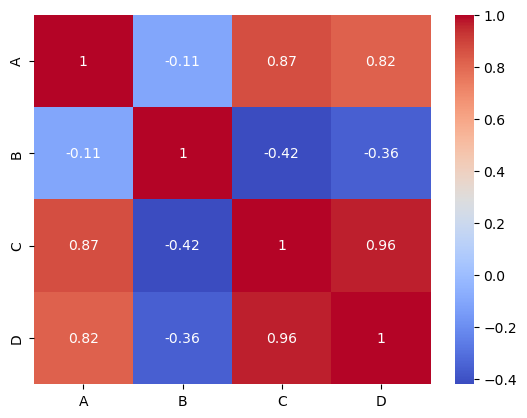

In [6]:
# get a correlation matrix for features
correlation_matrix = np.corrcoef(compounds_rescaled_features_only.T)
# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=compounds_rescaled_features_only.columns, yticklabels=compounds_rescaled_features_only.columns)
# Show the plot
plt.show()

Once again we see a high correlation between C and D (0.96), A and C are correlated (0.87), and A and D are too (0.82). Because the heatmap gives actual correlation values, it is much easier to see which ones are correlated than it is with the pairplot.

### 1b

In [7]:
class KMeans():
    def __init__(self, K, maximum_iters=100):
        # K: number of clusters to be created
        # distance matrix is Eucledian distance
        self.K = K
        self.maximum_iters = maximum_iters
    
    def cluster(self, input_points):
        """ 
        Do KMeans clustering

        Parameters
        ----------
        input_points: np.array shape(ndata,nfeatures). 
            Each feature is assumed to be normalized within range of [0,1]
        """
        centroids = np.random.random((self.K, input_points.shape[1]))
        assignments = np.zeros_like(input_points.shape[0])
        new_assignments = self.create_new_assignments(centroids, input_points)
        
        # restart if run into bad initialization (number of unique clusters is less than specified K)
        # Comment out this part for Q1.(d)
        if len(np.unique(new_assignments)) < self.K:
            return self.cluster(input_points)
        
        n_iters = 1
        # while cluster assignments are changing (not converged)
        while (new_assignments != assignments).any() and n_iters < self.maximum_iters:
            ### Compute the centroid given new assignment ###
            centroids = [np.mean(input_points[new_assignments== k], axis=0) for k in range(self.K)]
            assignments = new_assignments
            assignments = new_assignments
            ### Update the assignment with current centroids ###
            new_assignments = self.create_new_assignments(centroids, input_points)
            if len(np.unique(new_assignments)) < self.K:
                warnings.warn('At least one centroid vanishes')
            n_iters += 1
            if n_iters == self.maximum_iters:
                print("Warning: Maximum number of iterations reached!")
                
        return new_assignments


    def create_new_assignments(self, centroids, data_points):
        """
        Assign each datapoint to its nearest centroid.
        centroid: 2d array of the current centroid for each cluster
        data_points: 2d arrays recording the features of each data point.
        """
        ###Compute the distances that stores the Eucledian distances between each datapoints and the centroid ###
        #shape (ndata,ncentroid)
        #centroids.shape = data_points.shape
        distances = cdist(data_points, centroids, 'euclidean')
       # distances = np.sum(np.square(data_points - centroids), axis=1)
        new_assignments = np.argmin(distances, axis=-1)
        return new_assignments

We will do K Means clustering with K = 2, 3 and 4 clusters.

In [8]:
# initiate KMeans with 2, 3 and 4 clusters
kmeans_2 = KMeans(K= 2)
kmeans_3 = KMeans(K= 3)
kmeans_4 = KMeans(K= 4)

# cluster with 2, 3 and 4 clusters
assignments_k2 = kmeans_2.cluster(compounds_rescaled_features_only)
assignments_k3 = kmeans_3.cluster(compounds_rescaled_features_only)
assignments_k4 = kmeans_4.cluster(compounds_rescaled_features_only)

Now we visualize our results. Since C and D have the highest correlation, let's use them as features. for the first set of plots. We'll use A and C next.

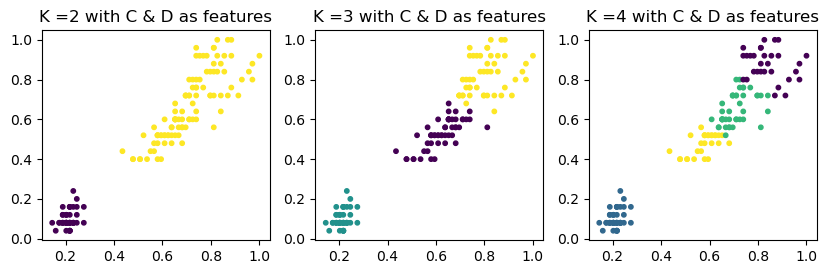

In [9]:
# visualize your results
plt.figure(figsize=(10, 6))

# scatter plot for 2 clusters. Use C & D as features
plt.subplot(2,3,1)
plt.scatter(compounds_rescaled['C'], compounds_rescaled['D'], c=assignments_k2, s=10)
plt.title('K =2 with C & D as features')

# scatter plot for 3 clusters
plt.subplot(2,3,2)
plt.scatter(compounds_rescaled['C'], compounds_rescaled['D'], c=assignments_k3, s=10)
plt.title('K =3 with C & D as features')

# scatter plot for 4 clusters
plt.subplot(2,3,3)
plt.scatter(compounds_rescaled['C'], compounds_rescaled['D'], c=assignments_k4, s=10)
plt.title('K =4 with C & D as features')

plt.show()

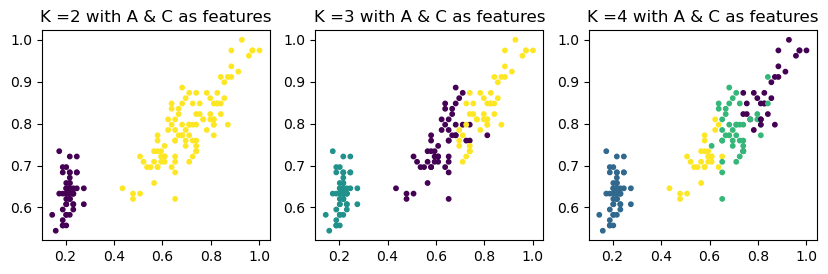

In [10]:
# visualize your results
plt.figure(figsize=(10, 6))

# scatter plot for 2 clusters. Use C & D as features
plt.subplot(2,3,1)
plt.scatter(compounds_rescaled['C'], compounds_rescaled['A'], c=assignments_k2, s=10)
plt.title('K =2 with A & C as features')

# scatter plot for 3 clusters
plt.subplot(2,3,2)
plt.scatter(compounds_rescaled['C'], compounds_rescaled['A'], c=assignments_k3, s=10)
plt.title('K =3 with A & C as features')

# scatter plot for 4 clusters
plt.subplot(2,3,3)
plt.scatter(compounds_rescaled['C'], compounds_rescaled['A'], c=assignments_k4, s=10)
plt.title('K =4 with A & C as features')

plt.show()

Three clusters makes the most sense. Although the two clusters are more neatly separated, they have members with very different characteristics. For example, a compound with 0.4 C value and 0.4 D value and another compound with 1.0 C value and 1.0 D value, although very different, are in the same cluster if we only make two.

### 1c
For K=3 clustering result, compare it to the true data label. How good is the classification?

In [11]:
def validate(y_hat,y):
    """
    Print accuracy of prediction for each class for the compounds dataset

    yhat: np.array shape(ndata). 
        Your prediction of classes
    y: np.array of str shape(ndata)
        Data labels / ground truths.
    """
    # correct classification
    compounds = np.unique(y) # should be ['amide','phenol','ether'] for compounds dataset
    clusters =[np.where((y==c)) for c in compounds]
    pred_class = np.unique(y_hat)
    
    #remove -1 for noise point in DBSCAN
    pred_class= np.delete(pred_class,np.where(pred_class==-1))
    assert len(pred_class) == len(compounds), f'y_hat has less or more than {len(compounds)} classes:{pred_class}'

    for i in range(3):
        #loop over solutions
        counts=[]
        scores=[]
        for j in range(3):
            #loop over clusters of true assignments
            sol_i= np.where((y_hat==pred_class[i]))
            counts.append(len(np.intersect1d(sol_i, clusters[j])))
            scores.append(counts[-1]/len(clusters[j]))
        idx = np.argmax(scores)
        print(f'Class {pred_class[i]} - {compounds[idx]}: {counts[idx]} out \
of {np.count_nonzero(clusters[idx])} are classified correctly')

In [12]:
validate(assignments_k3, compounds['type'])

Class 0 - amide: 48 out of 49 are classified correctly
Class 1 - phenol: 50 out of 50 are classified correctly
Class 2 - ether: 46 out of 50 are classified correctly


This is a very good (>90% correct) classification.

### 1d
Comment out the part of the code that reinitialize the centroid if the initial assignment is not
good. Run the KMeans algorithm multiple times with K=4, what problem do you see? Comment on how
the choice of initial centroids might affect the results and what are the possible solutions

In [13]:
import warnings

class KMeans():
    def __init__(self, K, maximum_iters=100):
        # K: number of clusters to be created
        # distance matrix is Eucledian distance
        self.K = K
        self.maximum_iters = maximum_iters
    
    def cluster(self, input_points):
        """ 
        Do KMeans clustering

        Parameters
        ----------
        input_points: np.array shape(ndata,nfeatures). 
            Each feature is assumed to be normalized within range of [0,1]
        """
        centroids = np.random.random((self.K, input_points.shape[1]))
        assignments = np.zeros_like(input_points.shape[0])
        new_assignments = self.create_new_assignments(centroids, input_points)
        
        # restart if run into bad initialization (number of unique clusters is less than specified K)
        # Comment out this part for Q1.(d)
        # if len(np.unique(new_assignments)) < self.K:
        #     return self.cluster(input_points)
        
        n_iters = 1
        # while cluster assignments are changing (not converged)
        while (new_assignments != assignments).any() and n_iters < self.maximum_iters:
            ### Compute the centroid given new assignment ###
            centroids = [np.mean(input_points[new_assignments== k], axis=0) for k in range(self.K)]
            assignments = new_assignments
            assignments = new_assignments
            ### Update the assignment with current centroids ###
            new_assignments = self.create_new_assignments(centroids, input_points)
            if len(np.unique(new_assignments)) < self.K:
                warnings.warn('At least one centroid vanishes')
            n_iters += 1
            if n_iters == self.maximum_iters:
                print("Warning: Maximum number of iterations reached!")
                
        return new_assignments


    def create_new_assignments(self, centroids, data_points):
        """
        Assign each datapoint to its nearest centroid.
        centroid: 2d array of the current centroid for each cluster
        data_points: 2d arrays recording the features of each data point.
        """
        ###Compute the distances that stores the Eucledian distances between each datapoints and the centroid ###
        #shape (ndata,ncentroid)
        #centroids.shape = data_points.shape
        distances = cdist(data_points, centroids, 'euclidean')
       # distances = np.sum(np.square(data_points - centroids), axis=1)
        new_assignments = np.argmin(distances, axis=-1)
        return new_assignments

/var/folders/m8/skfw9g2x4_g4pq5cv80_g24w0000gn/T/ipykernel_4349/143941416.py:38: UserWarning: At least one centroid vanishes
  warnings.warn('At least one centroid vanishes')


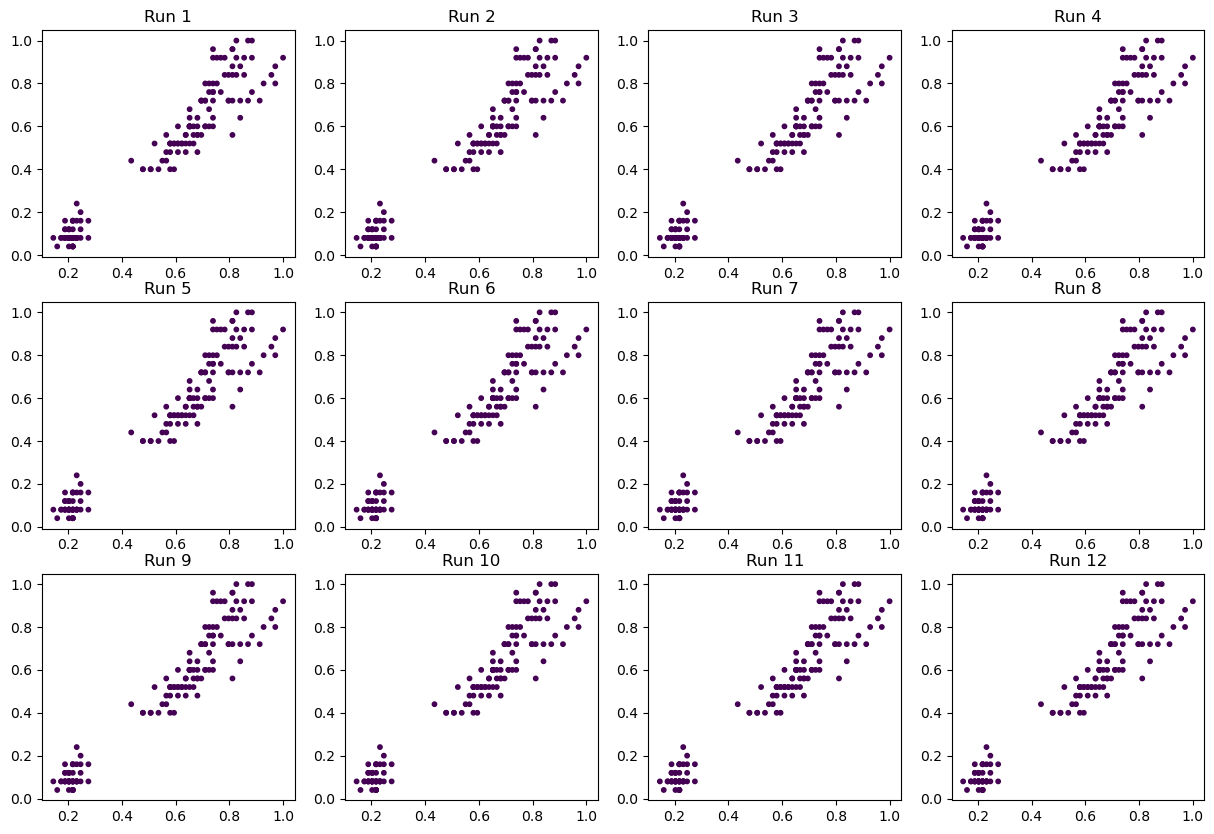

In [14]:
# initiate KMeans with 4 clusters again
kmeans_4_again = KMeans(K= 4)
# make 4 clusters again
reassignments_k4 = kmeans_4_again.cluster(compounds_rescaled_features_only)

# to visualize 12 runs, create 3 rows and 4 columns of subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
# loop to run K=4 12 times and visualize as scatter plots
for i, ax in enumerate(axes.ravel()):
    # Scatter plot for the i-th run
    ax.scatter(compounds_rescaled['C'], compounds_rescaled['D'], c=reassignments_k4, s=10)
    ax.set_title(f'Run {i + 1}')

plt.show()

All the centroids disappear and we end up with one cluster (which defeats the purpose of clustering).

The initial choice of centroids is important; if they are not well-chosen, the algorithm could converge to a local minimum instead of a global minimum. A way to prevent this would be to randomly choose initial centroids from within the dataset.

## 2 DBSCAN

DBSCAN Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN

### 2a
Use DBSCAN to classify compounds dataset. Adjust the Rcut and MinPts hyperparameters so that
we  have  3  clusters.  How  many  core,  border  and  noise  points  do  you  have  respectively?  Compared  to
KMeans, is DBSCAN more effective?

In [15]:
from sklearn.cluster import DBSCAN

# eps = Rcut, minsamples = MinPts
db1 = DBSCAN(eps= 0.1, min_samples= 3)
clustering = db1.fit(compounds_rescaled_features_only)

# Cluster labels assigned to each point in compounds_rescaled_features_only. Noisy samples are given the label -1.
#print(f'Clustering labels: \n {clustering.labels_}\n')
# Indices of core samples
#print(f'Core sample indices:\n {clustering.core_sample_indices_}\n')

# Check number of clusters
num_clusters = np.unique(clustering.labels_)
print(f'There are {num_clusters.size - 1} clusters') # minus 1 bc one of the indices is the noise points
# Number of core points
print(f'There are {clustering.core_sample_indices_.size} core points')
# Number of noise points
noise_points = np.count_nonzero(clustering.labels_ == -1) # check how many values in the array are -1
print(f'There are {noise_points} noise points')
# Number of border points
border_points = clustering.labels_.size - clustering.core_sample_indices_.size - noise_points
print(f'There are {border_points} border points')

There are 3 clusters
There are 134 core points
There are 11 noise points
There are 5 border points


The Rcut and MinPts that give 3 clusters and the smallest number of noise and border points are Rcut = 0.1 and MinPts = 3.

Core points: 134

Border points: 5

Noise points: 11

DBSCAN is a more effective classification method because the clusters are a lot more cleanly separated.

### 2b
Let’s work on the noisy moon dataset (provided in the reference code) instead. Try using DBSCAN
and one of KMeans with K=2. Visualize the clustering result. This time which method works better?

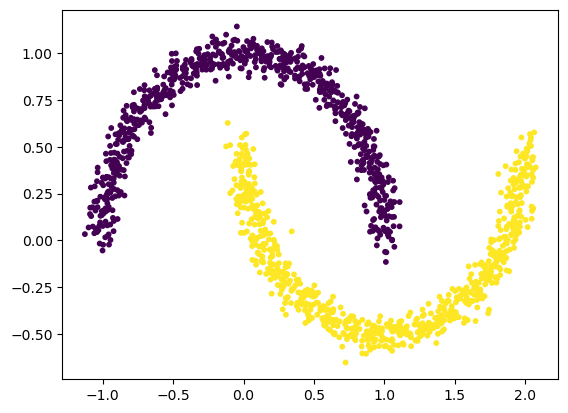

In [16]:
np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
# print(noisy_moons)
X, y = noisy_moons
plt.scatter(X[:, 0], X[:, 1], s=10,c=y)

In [17]:
db2 = DBSCAN(eps= 0.14, min_samples= 10)
clustering = db2.fit(X)

# Check number of clusters
num_clusters = np.unique(clustering.labels_)
print(f'There are {num_clusters.size - 1} clusters') # minus 1 bc one of the indices is the noise points
# Number of core points
print(f'There are {clustering.core_sample_indices_.size} core points')
# Number of noise points
noise_points = np.count_nonzero(clustering.labels_ == -1) # check how many values in the array are -1
print(f'There are {noise_points} noise points')
# Number of border points
border_points = clustering.labels_.size - clustering.core_sample_indices_.size - noise_points
print(f'There are {border_points} border points')

There are 1 clusters
There are 1496 core points
There are 0 noise points
There are 4 border points


Visualize results

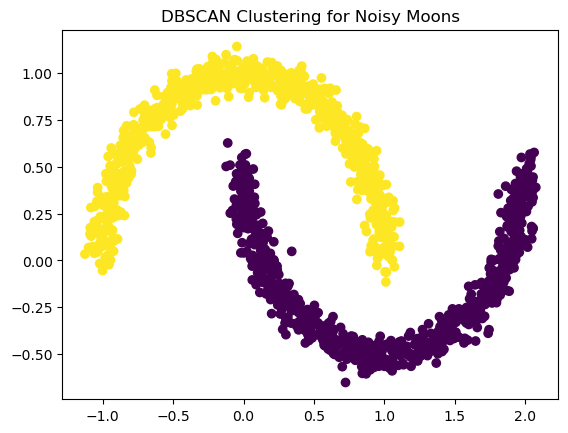

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_, cmap='viridis')
plt.title('DBSCAN Clustering for Noisy Moons')
plt.show()

Text(0.5, 1.0, 'KMeans Clustering for Noisy Moons')

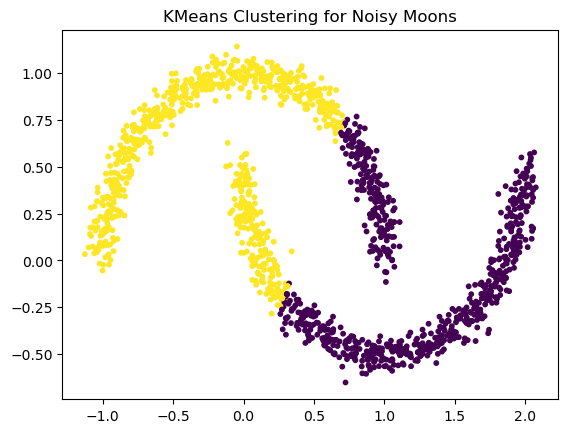

In [20]:
# initialize k means and form clusters with noisy moons
kmeans_moons = KMeans(K= 2)
moon_assignments = kmeans_2.cluster(X)

# scatter plot to visualize
plt.scatter(X[:, 0], X[:, 1], c=moon_assignments, s=10)
plt.title('KMeans Clustering for Noisy Moons')

In this case, density-based clustering is obviously the better choice. The result from KMeans clustering is laughable.